<a href="https://colab.research.google.com/github/tewbesta/COCO/blob/main/Homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Array of MNIST Images [courtesy of Wikipedia](https://en.wikipedia.org/wiki/MNIST_database#/media/File:MnistExamples.png)
Each handwritten digit is one item of the MNIST dataset

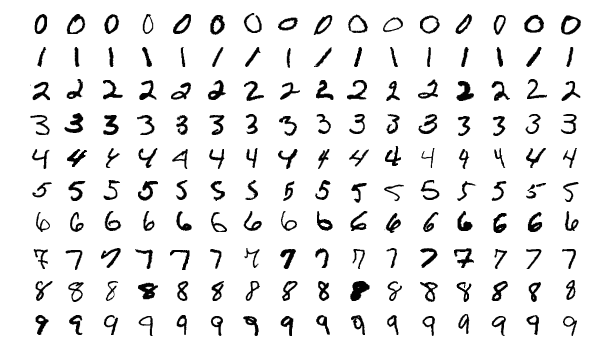

# ECE 595 Homework 1 - Training on GPU and RPi
In this homework, you will be tasked with training a neural network model on the GPU and a Raspberry Pi. Initially, you will test an untrained neural network model to see the accuracy of its predictions. Then you will incremently train the network, and port it to the Raspberry PI to see the difference in inference time compared to a dedicated GPU machine via Google Colab.

## Background Information
The MNIST dataset contains 60,000 images of handwritten numbers and is commonly used for evaluating classification neural networks. This homework will use the MNIST dataset, conveniently provided by PyTorch - the dataset will be automatically downloaded to your Google Colab runtime by the script below before doing any computations. 

## Given
* Starter code for all steps
* Log template for recording results of training and testing
* Testing / Training Code for RPi

## Deliverables
* Write code to evaluate untrained-neural network performance
* Write code to partially and fully train the neural network
* Port partially trained and trained models to RPi for evaluation
* A log of the time to train each model, classification accuracy for each step, and the time to evaluate the model on the RPi

# Steps
1. **(Colab)** Record accuracy on untrained model **(20 pts)**
2. **(Colab)** Train briefly, then record accuracy and training time **(20 pts)**
3. **(RPi)** Move model to RPi and record inference time **(30 pts)**
4. **(Colab)** Fully train model and record training time **(30 pts)**

# Instructions
## Google Colab
**Code that is meant to be written by you will appear between**
```### Student Code ###```
blocks. In addition, you can feel free to comment out the other Steps until you get to them. An alternative method is to simply include infinite loops between the steps to test your code. You can pause or stop the Colab Runtime at any time.

Refer to code comments for instructions on each step. It will be useful to refer to the [official PyTorch documentation](https://pytorch.org/docs/1.8.1/) when completing this homework and future homeworks. In addition, PyTorch provides [useful tutorials and examples for different topics](https://pytorch.org/tutorials/) which may be applicable to this homework. Note that nearly all of the software you need to write for each step is less than five lines of code - try and avoid over-engineering by referring to example code and documentation.

## RPi
For the RPi section of this homework, scripts are given to you - there is no need to write any software. Instead, you will be required to transfer your trained models downloaded from Google Colab to the RPi over SSH. This is an operating system dependent operation.

A script is provided to you, **rpi_hw1_test_model.py**. Note that these scripts must be added by you to your home directory. You should invoke the script in the following way:
```
python3 rpi_hw1_test_model.py 
```

### ThinLinc - Sending files to the RPI 
1. Run your Google Colab code
2. Use the folder icon on Google Colab, and find the model you want to send to the RPi **partially_trained_model.pt** or **fully_trained_model.pt**
3. Download the model to your machine
4. Use the **scp** command to send the downloaded model to one of the RPi's

Terminal Example:
```
scp -C <file_name> <username>@<host>:/<path>/<file_name>
scp -C partially_trained_model.pt yunglu@ee220crpi1.ecn.purdue.edu:/home/yunglu/
```

# Upload Instructions
**1)** Once you are finished, go to File -> Print -> Print to PDF. This will save your Google Colab output as a PDF, which you will include in the .ZIP you upload.

**2)** Include your **Homework_1.ipynb** in the .ZIP. You can go to File -> Download -> .ipynb



In [1]:
import random
import torch
import torch.nn
import torch.optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import sys
import time

### Set default tensor type to CPU float32
torch.set_default_tensor_type( torch.FloatTensor )
### Note: You must go to Runtime -> Change Runtime Type -> Select GPU for GPU acceleration
if torch.cuda.is_available():
  print("GPU acceleration available!")
else:
  print("You must go to Runtime -> Change Runtime Type -> Select GPU for GPU acceleration.")
  quit()

### Neural Network Model
### MNIST images are 1 channel 28x28 images
class MNIST_CNN( torch.nn.Module ):
  # Constructor
  def __init__(self):
    # Invoke constructor of nn.Model
    super(MNIST_CNN, self).__init__()
    # Initialize layers of network
    # Encoder Layer
    # Encoder 1
    self.conv1  = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)      # 4x28x28
    self.relu1  = torch.nn.ReLU()
    self.conv2  = torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)      # 8x28x28
    self.relu2  = torch.nn.ReLU()
    self.conv3  = torch.nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, stride=1, padding=1)     # 12x28x28
    self.relu3  = torch.nn.ReLU()
    self.conv4  = torch.nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)    # 16x28x28
    self.relu4  = torch.nn.ReLU()
    self.decode_conv5  = torch.nn.Conv2d(in_channels=16, out_channels=12, kernel_size=3, stride=1, padding=1)     # 12x28x28
    self.decode_relu5  = torch.nn.ReLU()
    self.decode_conv6  = torch.nn.Conv2d(in_channels=12, out_channels=8, kernel_size=3, stride=1, padding=1)    # 8x28x28
    self.decode_relu6  = torch.nn.ReLU()
    self.decode_conv7  = torch.nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=1, padding=1)    # 4x28x28
    self.decode_relu7  = torch.nn.ReLU()
    self.decode_conv8  = torch.nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3, stride=1, padding=1)    # 1x28x28
    self.decode_relu8  = torch.nn.ReLU()

    # Final Output Layers
    # Flatten 1x28x28 to 1x784
    # This is done in the forward(...) function

    # Create a fully connected layer followed by softmax to interpet the output of the neural network as confidences for the classes
    self.fully_connected = torch.nn.Linear(in_features=28*28, out_features=10)  # tensor of length 10
    self.softmax  = torch.nn.LogSoftmax(dim=1) # tensor of length 10, but entries are interpreted as probabilities

  def predict(self, input):
    # Do a forward pass to get a 1x10 tensor of class predcitions 
    x = self.forward( input.cuda() )
    # The final layer is LogSoftmax(...), so just use argmax to get the prediction
    x = torch.argmax( x )
    return x

  def forward(self, input):
    x = self.conv1( input.cuda() )
    x = self.relu1( x )
    x = self.conv2( x )
    x = self.relu2( x )
    x = self.conv3( x )
    x = self.relu3( x )
    x = self.conv4( x )
    x = self.relu4( x )
    x = self.decode_conv5( x )
    x = self.decode_relu5( x )
    x = self.decode_conv6( x )
    x = self.decode_relu6( x )
    x = self.decode_conv7( x )
    x = self.decode_relu7( x )
    x = self.decode_conv8( x )
    x = self.decode_relu8( x )
    x = x.view( 1, 28*28 )
    x = self.fully_connected( x )
    x = self.softmax( x )
    return x

### Step 0: Load the MNIST dataset and select a subset of it for training and inference
# Create transform to convert PIL Image to torch Tensor
# This includes converting the image data to floating point, and normalizing it around a mean and standard deviation
# Note the MNIST dataset pixel values are in the range [0.0, 255.0]. First we normalize the pixel values to a [0.0, 1.0] range then compute
# the mean and standard deviation across the dataset. 0.1307 and 0.3081 are the mean and standard deviation respecitvely of pixel values in MNIST
mnist_image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
# Load MNIST dataset 
mnist_dataset_train = datasets.MNIST("./MNIST/", train=True,  download=True, transform=mnist_image_transform)
mnist_dataset_test  = datasets.MNIST("./MNIST/", train=False, download=True, transform=mnist_image_transform)
# Create DataLoaders for the test and train dataset
mnist_train_dataloader  = torch.utils.data.DataLoader(mnist_dataset_train, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
mnist_test_dataloader   = torch.utils.data.DataLoader(mnist_dataset_test,  batch_size=1, shuffle=True, num_workers=0, pin_memory=False)

# Create a model instance
model = MNIST_CNN().cuda()


GPU acceleration available!


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Step 1

In [2]:
# Sample 500 images and pass them through the model
# Create an enumerable object to iterate over the input and labelled images
start_time = time.perf_counter_ns()
correct_classifications = 0
enumerable_test_dataloader = enumerate( mnist_test_dataloader )
for k in range(500):
  # Get input image and label pairs
  batchIndex, (image, label) = next( enumerable_test_dataloader )
  
  # Pass through the network
  with torch.no_grad():
    ### Start Student Code ###
    ### Instructions: Find the predicted class for the input image "image" by passing it through "model". You must assign the predicted class to a variable called "classification"
    ### Note, that the forward(...) function of "model" returns confidences for all 10 classes. Refer to the predict(...) function instead
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    classification=model.predict(image)
    ### End Student Code ###
  # Print if the classification was correct
  # print( "Predicted class was {}, actual class is {}".format(classification.item(), label.item()) )
  # Add to the number of correct classifications if correct
  correct_classifications += classification == label.cuda()
elapsed_time = ( time.perf_counter_ns() - start_time ) / 1000000000
# Use .item() to print the number of correct classifications a normal python integer rather than a tensor
print("Pre-Training: {}/500 Correct Predictions took {} seconds".format(correct_classifications.item(), elapsed_time))


Pre-Training: 40/500 Correct Predictions took 1.425446404 seconds


## Step 2

In [3]:
# Train the model over one epoch
start_time = time.perf_counter_ns()
loss_function       = torch.nn.NLLLoss()
learning_rate       = 0.01
learning_technique	= torch.optim.Adadelta(model.parameters(), lr=learning_rate)
# Do one training pass over the entire dataset
for batch_idx, (image, label) in enumerate( mnist_train_dataloader ):
  # Pass through model
  learning_technique.zero_grad()
  ### Begin Student Code ###
  # Pass through model
  ### Instructions: Pass each input image "image" through the "model", compute the loss, and perform backpropagation
  ### Tip: This can be done in three lines. 1) Use the forward(...) function of "model", compute the loss by passing "image" and "label" to "loss_function(...) as a function call"
  ### 3) invoke the .backpropagate() method on the computed l
  learning_technique.step()
elapsed_time = ( time.perf_counter_ns() - start_time ) / 1000000000
# Iterate over 500 images to test training results
# Create an enumerable object to iterate over the input and labelled images
correct_classifications = 0
enumerable_test_dataloader = enumerate( mnist_test_dataloader )
for k in range(500):
  # Get input image and label pairs
  batchIndex, (image, label) = next( enumerable_test_dataloader )
  # Pass through the network
  with torch.no_grad():
    classification = model.predict( image ) 
  # Add to the number of correct classifications if correct
  correct_classifications += classification == label.cuda()

# Use .item() to print the number of correct classifications a normal python integer rather than a tensor
print("Post-Training: {}/500 Correct Predictions, took {} seconds to train".format(correct_classifications.item(), elapsed_time))

# Save the trained model
torch.save( model.state_dict(), "partially_trained_model.pt" )

Post-Training: 53/500 Correct Predictions, took 25.446911636 seconds to train


Step 3

In [ ]:
The runtime on the rpi took Elapsed time (seconds): 102.223689472

## Step 4

In [4]:
### Step 5: Train the model further
### Start Student Code ###
### Instructions: Train over at 3 more epochs. A larger number of epochs will encourage the model to learn more but will take longer.
### 3 additional epochs should not taker longer than 45 minutes.
### You should start by copying over the entire training loop code from Step 2
for i in range(3):
    model.train()
    for batch_idx, (data, target) in enumerate(mnist_train_dataloader):
        data, target = data.to(device), target.to(device)
        learning_technique.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        learning_technique.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                i, batch_idx * len(data), len(mnist_train_dataloader),
                100. * batch_idx / len(mnist_train_dataloader), loss.item()))
            
### End Student Code ###
start_time = time.perf_counter_ns()
# Benchmark fully trained model
correct_classifications = 0
enumerable_test_dataloader = enumerate( mnist_test_dataloader )
for k in range(500):
  # Get input image and label pairs
  batchIndex, (image, label) = next( enumerable_test_dataloader )
  # Pass through the network
  with torch.no_grad():
    classification = model.predict( image ) 
  # Add to the number of correct classifications if correct
  correct_classifications += classification == label.cuda()
elapsed_time = ( time.perf_counter_ns() - start_time ) / 1000000000
# Use .item() to print the number of correct classifications a normal python integer rather than a tensor
print("Post-Full-Training: {}/500 Correct Predictions took {} seconds".format(correct_classifications.item(), elapsed_time))

# Save the trained model
torch.save( model.state_dict(), "trained_model.pt" )


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.383577
Train Epoch: 0 [50/60000 (0%)]	Loss: 2.154093
Train Epoch: 0 [100/60000 (0%)]	Loss: 2.311167
Train Epoch: 0 [150/60000 (0%)]	Loss: 2.329092
Train Epoch: 0 [200/60000 (0%)]	Loss: 2.343666
Train Epoch: 0 [250/60000 (0%)]	Loss: 2.199559
Train Epoch: 0 [300/60000 (0%)]	Loss: 2.406188
Train Epoch: 0 [350/60000 (1%)]	Loss: 2.197666
Train Epoch: 0 [400/60000 (1%)]	Loss: 2.354883
Train Epoch: 0 [450/60000 (1%)]	Loss: 2.408247
Train Epoch: 0 [500/60000 (1%)]	Loss: 2.360656
Train Epoch: 0 [550/60000 (1%)]	Loss: 2.189492
Train Epoch: 0 [600/60000 (1%)]	Loss: 2.201868
Train Epoch: 0 [650/60000 (1%)]	Loss: 2.183780
Train Epoch: 0 [700/60000 (1%)]	Loss: 2.293618
Train Epoch: 0 [750/60000 (1%)]	Loss: 2.360467
Train Epoch: 0 [800/60000 (1%)]	Loss: 2.154989
Train Epoch: 0 [850/60000 (1%)]	Loss: 2.156483
Train Epoch: 0 [900/60000 (2%)]	Loss: 2.372293
Train Epoch: 0 [950/60000 (2%)]	Loss: 2.264382
Train Epoch: 0 [1000/60000 (2%)]	Loss: 2.234184
Train Epoch: 0 

**RPi Log - Inference Time for 500 images**

**For reference: On a NVIDIA GTX 1080** inference is roughly 0.561 - 0.686 seconds

Inference time on RPi:

